![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+ML%2FForecasting&file=BigQuery+ML+For+Hierarchical+Forecasting.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20ML/Forecasting/BigQuery%20ML%20For%20Hierarchical%20Forecasting.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520ML%2FForecasting%2FBigQuery%2520ML%2520For%2520Hierarchical%2520Forecasting.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20ML/Forecasting/BigQuery%20ML%20For%20Hierarchical%20Forecasting.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20ML/Forecasting/BigQuery%20ML%20For%20Hierarchical%20Forecasting.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# BigQuery ML For Hierarchical Forecasting

This notebook explores hierarchical time series forecasting using [BigQuery ML (BQML)]((https://cloud.google.com/bigquery/docs/e2e-journey)). Hierarchical forecasting is essential in many business contexts, such as retail, where predictions are needed not just at the lowest level (e.g., store sales) but also at aggregated levels (e.g., city, county, state totals).

**Goal:**
The primary goal is to demonstrate and compare two distinct approaches for hierarchical forecasting within the BigQuery environment:
1.  **BQML Built-in Hierarchical Forecasting:** Utilizing the `ARIMA_PLUS` model with the `hierarchical_time_series_cols` option, which defaults to a bottom-up aggregation method. See the [BQML Hierarchical Time Series documentation](https://cloud.google.com/bigquery/docs/arima-time-series-forecasting-with-hierarchical-time-series).
2.  **Custom Top-Down Disaggregation:** Implementing a top-down approach using the "forecast proportions" method. This involves training base `ARIMA_PLUS` models for all levels and then disaggregating the top-level forecast proportionally using SQL logic. For general concepts on hierarchical methods, see [Forecasting: Principles and Practice (FPP3) - Chapter 11](https://otexts.com/fpp3/hierarchical.html).

**Data Source:**
We use the Iowa Liquor Sales public dataset available in BigQuery (`bigquery-public-data.iowa_liquor_sales.sales`), focusing on daily `bottles_sold` aggregated to `total_units_sold` per store. The hierarchy explored is **State > County > City > Store**.

**Workflow Steps:**
1.  **Data Preparation:** The raw data is filtered (specific counties, active stores), aggregated per store, and split into 'TRAIN' and 'TEST' sets.
2.  **BQML Bottom-Up Model:** An `ARIMA_PLUS` model (`hierarchical_forecast`) is trained using BQML's built-in hierarchical features. We then verify its bottom-up aggregation logic through comparison queries.
3.  **Custom Top-Down Preparation:**
    * A dedicated view (`prepped_topdown`) is created to explicitly represent each series at every hierarchy level.
    * A multi-series `ARIMA_PLUS` model (`topdown_forecast`) is trained on this view to generate raw forecasts for all levels ([BQML CREATE MODEL syntax](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series)).
4.  **Custom Top-Down Implementation:** A SQL query implements the forecast proportions method, disaggregating the state-level forecast down to the store level, storing results in `topdown_results`.
5.  **Accuracy Comparison:** MAE, RMSE, and MAPE are manually calculated for both methods over the first 14 days of the test set for every series in the hierarchy.
6.  **Analysis:** The accuracy results are loaded into a pandas DataFrame for local analysis and visualization, comparing the performance of the two approaches overall and at each specific hierarchy level.

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [68]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-bigquery'),
    ('numpy', 'numpy'),
    ('pandas', 'pandas'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [4]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

Inputs

In [5]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [6]:
REGION = 'us-central1'
SERIES = 'applied-ml-forecasting'
EXPERIMENT = 'bqml-hierarchical'

Packages

In [7]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Optional, but can make plots nicer

# Optional: Improve plot appearance
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

Clients

In [8]:
# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# bigquery cell magics
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Prepare the code below for your environment.

This notebook takes advantage of the [BigQuery IPython magic](https://cloud.google.com/python/docs/reference/bigquery/latest/magics) for legibility and ease of copy/pasting to BigQuery SQL editor. If this notebook is being used from an environment that can run notebooks it needs further preparation: Colab, Colab Enterprise, Vertex AI Workbench Instances, or BigQuery Studio with a Python Notebook. The SQL code in these cells uses the fully qualified [BigQuery table](https://cloud.google.com/bigquery/docs/tables-intro) names in the form `projectname.datasetname.tablename`. Prepare for your environment by:

- Edit > Find
    - Find: `statmike-mlops-349915`
    - Replace: `<your project id>`
    - Replace All

---
## BigQuery Source Data

This workflow uses data collected from products being sold in stores.  It could be used to forecast product demand at the store level as well as considering the hierarcy of `State | County | City | Store`.  The data are found in the BigQuery Public dataset at:

- `bigquery-public-data.iowa_liquor_sales.sales`

In [9]:
%%bigquery
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,RINV-05110400027,2024-01-30,2647,HY-VEE #7 / CEDAR RAPIDS,5050 EDGEWOOD RD,CEDAR RAPIDS,52411.0,POINT(-91.698522983 42.029484381),None,LINN,...,43120,BACARDI SUPERIOR PET,6,1750,15.50,23.25,-48,-1116.00,-84.0,-22.19
1,RINV-05297200096,2024-06-11,2621,HY-VEE FOOD STORE #3 / SIOUX CITY,3301 GORDON DR,SIOUX CITY,51105.0,POINT(-96.362866022 42.488984001),None,WOODBURY,...,36908,MCCORMICK 80PRF VODKA PET,6,1750,8.24,12.36,-12,-148.32,-21.0,-5.54
2,RINV-05455500010,2024-10-03,2643,HY-VEE WINE AND SPIRITS / WATERLOO,2126 KIMBALL AVE,WATERLOO,50701.0,POINT(-92.35698 42.47029),None,BLACK HAWK,...,64865,FIREBALL CINNAMON WHISKEY PET,12,750,9.00,13.50,-24,-324.00,-18.0,-4.75
3,RINV-04806800054,2023-08-16,5145,SOUTH SIDE FOOD MART,1101 ARMY POST RD. SUITE A & B,DES MOINES,50315.0,POINT(-93.628625001 41.526920009),None,POLK,...,31470,NEW AMSTERDAM GIN,12,1000,7.83,11.75,-12,-141.00,-12.0,-3.17
4,RINV-05394100050,2024-08-20,2606,HY-VEE WINE AND SPIRITS / HUMBOLDT,1011 13TH ST NORTH,HUMBOLDT,50548.0,POINT(-94.226730035 42.733207011),None,HUMBOLDT,...,35917,FIVE O'CLOCK VODKA,12,1000,4.66,6.99,-12,-83.88,-12.0,-3.17


### Describe Data with `ML.DESCRIBE_DATA`

Reviewing a few records, like above, gives a good sense of how the data is arranged. Before proceeding with machine learning techniques it is important to understand more about these raw columns.  Are they ready to use a features in a model or is some form of feature engineering needed first?  For this, the distribution of values is an important starting point.  

While SQL could be used to look at the distribution, it would be a time consuming process and requires different techniques for different data types like numerical, string, boolean, dates, times, array and struct version of these, and arrays of structs.

To make this process fast and simple, the new [`ML.DESCRIBE_DATA`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-describe-data) function is used to get a single row for each column the describes the data distribution:
- `top_k`: get the top 3 most frequent categories for string columns (default = 1)
- `num_quantiles`: get 4 quantiles for numerical columns (default = 2)

In [10]:
%%bigquery
SELECT *
FROM ML.DESCRIBE_DATA(
    (SELECT * EXCEPT(store_location) FROM `bigquery-public-data.iowa_liquor_sales.sales`),
    STRUCT(3 AS top_k, 4 AS num_quantiles)
)

Query is running:   0%|          |

Downloading:   0%|          |

,name,num_rows,num_nulls,num_zeros,min,max,mean,stddev,median,quantiles,unique,avg_string_length,num_values,top_values,min_array_length,max_array_length,avg_array_length,total_array_length,array_length_quantiles,dimension
0,address,31339341,83720,<NA>,1 E MAIN ST,PO BOX 261 310 W DILLON,NaN,NaN,NaN,[],3199,16.002626,31255621,"[{'value': '3221 SE 14TH ST', 'count': 345286}...",<NA>,<NA>,NaN,<NA>,[],<NA>
1,bottle_volume_ml,31339341,0,10,0,378000,870.840142,619.444568,750.00,"[0.0, 750.0, 750.0, 1000.0, 378000.0]",<NA>,NaN,31339341,[],<NA>,<NA>,NaN,<NA>,[],<NA>
2,bottles_sold,31339341,0,9,-768,15000,10.915819,30.769464,6.00,"[-768.0, 3.0, 6.0, 12.0, 15000.0]",<NA>,NaN,31339341,[],<NA>,<NA>,NaN,<NA>,[],<NA>
3,category,31339341,16974,<NA>,1011000.0,1901200.0,NaN,NaN,NaN,[],114,9.000000,31322367,"[{'value': '1031100.0', 'count': 3344482}, {'v...",<NA>,<NA>,NaN,<NA>,[],<NA>
4,category_name,31339341,25040,<NA>,100 PROOF VODKA,WHITE RUM,NaN,NaN,NaN,[],103,17.457523,31314301,"[{'value': 'AMERICAN VODKAS', 'count': 3250690...",<NA>,<NA>,NaN,<NA>,[],<NA>
5,city,31339341,83719,<NA>,ACKLEY,ZWINGLE,NaN,NaN,NaN,[],501,9.193062,31255622,"[{'value': 'DES MOINES', 'count': 2664255}, {'...",<NA>,<NA>,NaN,<NA>,[],<NA>
6,county,31339341,160522,<NA>,ADAIR,WRIGHT,NaN,NaN,NaN,[],100,6.428723,31178819,"[{'value': 'POLK', 'count': 5831419}, {'value'...",<NA>,<NA>,NaN,<NA>,[],<NA>
7,county_number,31339341,7206498,<NA>,1,99,NaN,NaN,NaN,[],99,1.912535,24132843,"[{'value': None, 'count': 7206498}, {'value': ...",<NA>,<NA>,NaN,<NA>,[],<NA>
8,date,31339341,0,<NA>,2012-01-03,2025-03-31,NaN,NaN,NaN,[],3492,10.000000,31339341,"[{'value': '2015-04-29', 'count': 35482}, {'va...",<NA>,<NA>,NaN,<NA>,[],<NA>
9,invoice_and_item_number,31339341,0,<NA>,306831300001,S444400083,NaN,NaN,NaN,[],31649878,14.054386,31339341,"[{'value': 'INV-60784400016', 'count': 324}, {...",<NA>,<NA>,NaN,<NA>,[],<NA>


### Create A BigQuery Dataset

Create a new [BigQuery Dataset](https://cloud.google.com/bigquery/docs/datasets) as a working location for this workflow:

In [11]:
%%bigquery
CREATE SCHEMA IF NOT EXISTS `statmike-mlops-349915.applied_ml_forecasting`
    OPTIONS(
        location = 'US'
    )

Query is running:   0%|          |

""


### Prepare Base Source Table

This query creates the base table (`applied_ml_forecasting.source`) needed for the forecasting project. It selects data from the `bigquery-public-data.iowa_liquor_sales.sales` dataset, applying two filters:
1.  Includes only data from POLK, LINN, and SCOTT counties.
2.  Includes only stores that had sales activity 4 weeks prior to the latest date in the public dataset (ensuring relevance).

Finally, it aggregates `bottles_sold` into a daily sum per store, renaming it `total_units_sold`.


In [12]:
%%bigquery
CREATE OR REPLACE TABLE `statmike-mlops-349915.applied_ml_forecasting.source` AS
WITH DateRange AS (
    SELECT
        MAX(date) AS max_date
    FROM `bigquery-public-data.iowa_liquor_sales.sales`
),
ActiveStores AS (
    SELECT DISTINCT store_number
    FROM `bigquery-public-data.iowa_liquor_sales.sales`
    WHERE date = (SELECT DATE_SUB(max_date, INTERVAL 4 WEEK) FROM DateRange)
)
SELECT
    store_number,
    city,
    county,
    date,
    SUM(bottles_sold) AS total_units_sold
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE county IN ('POLK', 'LINN', 'SCOTT')
    AND store_number IN (SELECT store_number FROM ActiveStores)
GROUP BY store_number, date, city, county;

Query is running:   0%|          |

""


In [13]:
%%bigquery
SELECT
    county,
    city,
    store_number,
    COUNT(*) AS row_count
FROM `statmike-mlops-349915.applied_ml_forecasting.source`
GROUP BY county, city, store_number;

Query is running:   0%|          |

Downloading:   0%|          |

,county,city,store_number,row_count
0,POLK,ALTOONA,2548,939
1,POLK,ANKENY,10074,143
2,SCOTT,BETTENDORF,10065,153
3,SCOTT,BETTENDORF,2687,134
4,SCOTT,BETTENDORF,4699,249
...,...,...,...,...
110,POLK,WEST DES MOINES,5873,303
111,POLK,WEST DES MOINES,6044,81
112,POLK,WEST DES MOINES,6046,133
113,POLK,WEST DES MOINES,6119,282


### Prepare Base Source Table

This query creates the base table (`applied_ml_forecasting.source`) needed for the forecasting project. It selects data from the `bigquery-public-data.iowa_liquor_sales.sales` dataset, applying two filters:
1.  Includes only data from POLK, LINN, and SCOTT counties.
2.  Includes only stores that had sales activity 4 weeks prior to the latest date in the public dataset (ensuring relevance).

Finally, it aggregates `bottles_sold` into a daily sum per store, renaming it `total_units_sold`.


In [14]:
%%bigquery
CREATE OR REPLACE TABLE `statmike-mlops-349915.applied_ml_forecasting.prepped` AS
WITH DateRange AS (
    SELECT
        MAX(date) AS max_date
    FROM `statmike-mlops-349915.applied_ml_forecasting.source`
)
SELECT
    *,
    CASE
        WHEN date > DATE_SUB((SELECT max_date FROM DateRange), INTERVAL 4 WEEK) THEN 'TEST'
        ELSE 'TRAIN'
    END AS splits
FROM `statmike-mlops-349915.applied_ml_forecasting.source`

Query is running:   0%|          |

""


---
## Base-Level Forecasting With BigQuery ML's ARIMA+

Start by creating forecast for the lowest level of the hierarchy, the stores, directly.  This creates a forecast model for each time series represented by `time_series_id_col = ['county', 'city', 'store_number']` which is really just `store_number` since they are uniquely numbered.

### Train Base Forecast Model (Store-Level ARIMA+)

This code trains the initial BigQuery ML forecast model (`applied_ml_forecasting.base_forecast`) using the `ARIMA_PLUS` algorithm.

-   **Input Data:** Uses the `prepped` table, filtered to include only the 'TRAIN' data split.
-   **Time Series Definition:** Sets `time_series_id_col = ['county', 'city', 'store_number']`. This instructs BigQuery ML to train a separate ARIMA+ model for each unique store, treating each store's sales history as an independent time series.
-   **Configuration:** Specifies 'US' holidays, daily data frequency, and a forecast horizon of 90 days.

This model generates forecasts specifically at the lowest level of the hierarchy (store level).

In [15]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_ml_forecasting.base_forecast`
OPTIONS (
    model_type = 'ARIMA_PLUS',
    time_series_timestamp_col = 'date',
    time_series_data_col = 'total_units_sold',
    time_series_id_col = ['county', 'city', 'store_number'],
    holiday_region = 'US',
    data_frequency = 'DAILY',
    horizon = 90
) AS
SELECT * EXCEPT(splits)
FROM `statmike-mlops-349915.applied_ml_forecasting.prepped`
WHERE splits = 'TRAIN'

Query is running:   0%|          |

""


### Generate Forecasts from Base Model

This query uses the `ML.FORECAST` function to generate predictions using the trained store-level model (`applied_ml_forecasting.base_forecast`).

-   **Horizon:** Explicitly set to `1`, requesting only a 1-day forecast beyond the training data.
-   **Confidence Level:** Set to `0.95`, requesting the 95% prediction intervals.

The output includes the `forecast_timestamp`, the predicted `forecast_value`, standard error, and the prediction interval bounds (`confidence_interval_lower_bound`, `confidence_interval_upper_bound`) for each store. The results are ordered for easier review.

*(Note: The `horizon` parameter in `ML.FORECAST` overrides the horizon set during model training for this specific prediction run. If `horizon` were omitted here, it would default to the model's training horizon, which was 90 days.)*

Reference: [`ML.FORECAST` documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-forecast)

In [16]:
%%bigquery
SELECT *
FROM ML.FORECAST(
    MODEL `statmike-mlops-349915.applied_ml_forecasting.base_forecast`,
    STRUCT(1 AS horizon, 0.95 AS confidence_level)
)
ORDER BY county, city, store_number, forecast_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

,store_number,city,county,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,10208,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,385.608940,30.239660,0.95,326.446314,444.771567,326.446314,444.771567
1,10300,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,231.328704,34.298202,0.95,164.225708,298.431699,164.225708,298.431699
2,10523,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,704.094643,59.387464,0.95,587.905558,820.283728,587.905558,820.283728
3,2508,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,987.328942,89.450017,0.95,812.323733,1162.334152,812.323733,1162.334152
4,2552,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,763.623463,133.187624,0.95,503.047459,1024.199467,503.047459,1024.199467
...,...,...,...,...,...,...,...,...,...,...,...
110,10241,LE CLAIRE,SCOTT,2025-03-04 00:00:00+00:00,16.790718,39.429072,0.95,-60.350610,93.932046,-60.350610,93.932046
111,5156,LE CLAIRE,SCOTT,2025-03-04 00:00:00+00:00,138.958042,3.985834,0.95,131.159925,146.756159,131.159925,146.756159
112,5656,LE CLAIRE,SCOTT,2025-03-04 00:00:00+00:00,107.735031,23.401455,0.95,61.951065,153.518998,61.951065,153.518998
113,4911,PRINCETON,SCOTT,2025-03-04 00:00:00+00:00,102.302179,4.457706,0.95,93.580863,111.023495,93.580863,111.023495


### Evaluate Base Forecast Model Performance

This query uses the `ML.EVALUATE` function to assess the performance of the trained `base_forecast` model.

-   **Evaluation Data:** It compares the model's predictions against the actual values in the 'TEST' data split from the `prepped` table.
-   **Aggregation:** `perform_aggregation` is set to `TRUE`. This instructs `ML.EVALUATE` to calculate metrics (like MAE, RMSE, MAPE, etc.) aggregated **for each time series** defined in the model (i.e., providing evaluation results per store). If set to `FALSE`, metrics would be calculated per timestamp instead.

The output provides a performance summary for each individual store forecast based on the test data. Results are ordered by store identifiers.

Reference: [`ML.EVALUATE` documentation for ARIMA_PLUS](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)

In [17]:
%%bigquery
SELECT *
FROM ML.EVALUATE(
    MODEL `statmike-mlops-349915.applied_ml_forecasting.base_forecast`,
    (
        SELECT *
        FROM `statmike-mlops-349915.applied_ml_forecasting.prepped`
        WHERE splits = 'TEST'
        ORDER BY county, city, store_number
    ),
    STRUCT(TRUE AS perform_aggregation)
)
ORDER BY county, city, store_number

Query is running:   0%|          |

Downloading:   0%|          |

,store_number,city,county,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,10208,CEDAR RAPIDS,LINN,62.321366,5750.049473,75.829081,18.768092,17.447772
1,10300,CEDAR RAPIDS,LINN,71.857748,9489.803982,97.415625,12.280133,13.883940
2,10523,CEDAR RAPIDS,LINN,123.052960,22244.916402,149.147298,16.257461,16.740826
3,2508,CEDAR RAPIDS,LINN,226.674811,86273.541266,293.723580,40.504712,29.251267
4,2552,CEDAR RAPIDS,LINN,596.206716,448791.412325,669.918960,18200.240978,130.556931
...,...,...,...,...,...,...,...,...
107,10241,LE CLAIRE,SCOTT,59.844502,5062.056257,71.148129,49.464377,36.248738
108,5156,LE CLAIRE,SCOTT,125.480395,15745.329418,125.480395,47.173081,61.733994
109,5656,LE CLAIRE,SCOTT,107.170796,14526.968139,120.527873,55.909397,79.487944
110,4911,PRINCETON,SCOTT,235.105901,55274.784582,235.105901,75.596753,121.535015


---
## Hierarchical Forecasting With BigQuery ML's ARIMA+

Provide the hierarchy when creating the forecast with `hierarchical_time_series_cols = ['county', 'city', 'store_number']`.  This will automatically create an overall forecast as well so no need to specify the `state` which is always 'Iowa' in this data.

### Train Hierarchical ARIMA+ Forecast Model

This query trains another `ARIMA_PLUS` model (`applied_ml_forecasting.hierarchical_forecast`), this time leveraging BigQuery ML's built-in hierarchical forecasting capabilities.

-   **Key Option:** The parameter `hierarchical_time_series_cols = ['county', 'city', 'store_number']` is added. This defines the hierarchy structure (County -> City -> Store).
-   **Automatic Aggregation:** Based on this option, BigQuery ML automatically trains models for the base level (store, defined by `time_series_id_col`) and also generates forecasts for the aggregated upper levels (city totals, county totals, and the overall total).
-   **Input & Other Parameters:** Uses the 'TRAIN' data split, specifies US holidays, daily frequency, and a 90-day horizon, similar to the base model.

*(Important Context: This built-in BigQuery ML approach performs **bottom-up aggregation** by default, meaning higher-level forecasts are derived from the sum of their respective lower-level forecasts.)*

In [18]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`
OPTIONS (
    model_type = 'ARIMA_PLUS',
    time_series_timestamp_col = 'date',
    time_series_data_col = 'total_units_sold',
    time_series_id_col = ['county', 'city', 'store_number'],
    hierarchical_time_series_cols = ['county', 'city', 'store_number'],
    holiday_region = 'US',
    data_frequency = 'DAILY',
    horizon = 90
) AS
SELECT * EXCEPT(splits)
FROM `statmike-mlops-349915.applied_ml_forecasting.prepped`
WHERE splits = 'TRAIN'

Query is running:   0%|          |

""


### Generate Forecasts from Hierarchical Model

This query uses the `ML.FORECAST` function to generate predictions using the trained `hierarchical_forecast` model.

-   **Horizon:** Explicitly set to `1`, requesting only a 1-day forecast.
-   **Confidence Level:** Set to `0.95`, requesting the 95% prediction intervals.
-   **Output Levels:** Since this model includes hierarchy definitions (`hierarchical_time_series_cols`), the output contains forecasts for **all levels**: individual stores, plus the automatically aggregated city totals, county totals, and the overall total. The level of aggregation for each row can be identified by which `time_series_id_col` values (`county`, `city`, `store_number`) are non-NULL.

The results include `forecast_timestamp`, `forecast_value`, prediction intervals, etc., for each forecasted series at every level of the hierarchy. Results are ordered for review.

*(Note: The `horizon` parameter in `ML.FORECAST` overrides the model's training horizon (90 days) for this specific prediction run. If `horizon` were omitted here, the full 90-day forecast would be generated.)*

Reference: [`ML.FORECAST` documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-forecast)

In [19]:
%%bigquery
SELECT *
FROM ML.FORECAST(
    MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`,
    STRUCT(1 AS horizon, 0.95 AS confidence_level)
)
ORDER BY county, city, store_number, forecast_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

,store_number,city,county,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,None,None,None,2025-03-04 00:00:00+00:00,61328.676967,7795.136399,0.95,46077.819283,76579.534651,46077.819283,76579.534651
1,None,None,LINN,2025-03-04 00:00:00+00:00,16974.738077,1569.772687,0.95,13903.543602,20045.932552,13903.543602,20045.932552
2,None,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,14749.377260,1134.597054,0.95,12529.585673,16969.168848,12529.585673,16969.168848
3,10208,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,385.608940,30.239660,0.95,326.446314,444.771567,326.446314,444.771567
4,10300,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,231.328704,34.298202,0.95,164.225708,298.431699,164.225708,298.431699
...,...,...,...,...,...,...,...,...,...,...,...
132,5656,LE CLAIRE,SCOTT,2025-03-04 00:00:00+00:00,107.735031,23.401455,0.95,61.951065,153.518998,61.951065,153.518998
133,None,PRINCETON,SCOTT,2025-03-04 00:00:00+00:00,102.302179,4.457706,0.95,93.580863,111.023495,93.580863,111.023495
134,4911,PRINCETON,SCOTT,2025-03-04 00:00:00+00:00,102.302179,4.457706,0.95,93.580863,111.023495,93.580863,111.023495
135,None,WALCOTT,SCOTT,2025-03-04 00:00:00+00:00,377.546652,8.179839,0.95,361.543140,393.550164,361.543140,393.550164


### Evaluate Hierarchical Forecast Model Performance

This query uses the `ML.EVALUATE` function to assess the performance of the trained `hierarchical_forecast` model.

-   **Evaluation Data:** Compares the model's predictions against the actual values in the 'TEST' data split from the `prepped` table.
-   **Aggregation:** `perform_aggregation` is set to `TRUE`.
-   **Output Levels:** For a hierarchical model, this setting calculates evaluation metrics (like MAE, RMSE, MAPE) aggregated **for each forecasted time series at all levels** of the hierarchy (individual stores, aggregated cities, aggregated counties, and the overall total). The specific level for each row of metrics is identified by the non-NULL values in the `county`, `city`, and `store_number` columns.

The output provides distinct performance metrics for every series automatically forecasted by the hierarchical model, allowing assessment across the different aggregation levels. Results are ordered for review.

Reference: [`ML.EVALUATE` documentation for ARIMA_PLUS](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)

In [20]:
%%bigquery
SELECT *
FROM ML.EVALUATE(
    MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`,
    (
        SELECT *
        FROM `statmike-mlops-349915.applied_ml_forecasting.prepped`
        WHERE splits = 'TEST'
        ORDER BY county, city, store_number
    ),
    STRUCT(TRUE AS perform_aggregation)
)
ORDER BY county, city, store_number

Query is running:   0%|          |

Downloading:   0%|          |

,store_number,city,county,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,10208,CEDAR RAPIDS,LINN,62.321366,5750.049473,75.829081,18.768092,17.447772
1,10300,CEDAR RAPIDS,LINN,71.857748,9489.803982,97.415625,12.280133,13.883940
2,10523,CEDAR RAPIDS,LINN,123.052960,22244.916402,149.147298,16.257461,16.740826
3,2508,CEDAR RAPIDS,LINN,226.674811,86273.541266,293.723580,40.504712,29.251267
4,2552,CEDAR RAPIDS,LINN,596.206716,448791.412325,669.918960,18200.240978,130.556931
...,...,...,...,...,...,...,...,...
107,10241,LE CLAIRE,SCOTT,59.844502,5062.056257,71.148129,49.464377,36.248738
108,5156,LE CLAIRE,SCOTT,125.480395,15745.329418,125.480395,47.173081,61.733994
109,5656,LE CLAIRE,SCOTT,107.170796,14526.968139,120.527873,55.909397,79.487944
110,4911,PRINCETON,SCOTT,235.105901,55274.784582,235.105901,75.596753,121.535015


---
## Compare Base-Level Forecasting To Hierarchical Forecasting

The hierarchical forecast aggregates base-level forecasts. For each time point and level of the hierarchy (store, city, county, state), the hierarchical forecast value is derived by summing the base-level forecasts of the constituent lower-level entities. Specifically, store forecasts are summed to obtain city forecasts, city forecasts are summed for county forecasts, and county forecasts are summed for the state forecast.

### Step 1: Compare Store-Level Forecasts (Base vs. Hierarchical)

This query performs the initial check in the comparison process by focusing on the lowest level of the hierarchy – an individual store. It retrieves forecasts for a single example store ('10523') over a 10-day horizon from two distinct models:

1.  **`base_forecast`**: The model trained only on individual store-level time series.
2.  **`hierarchical_forecast`**: The model trained using BigQuery ML's built-in hierarchical capabilities.

The results are joined side-by-side. The goal is to verify if the forecast value generated by the simple base model matches the corresponding store-level forecast extracted from the hierarchical model for the same store and timestamp. For a bottom-up approach, these values are expected to be identical.

In [21]:
%%bigquery
WITH
baseForecast AS (
    SELECT store_number, city, county, forecast_timestamp, forecast_value AS base_forecast_value
    FROM ML.FORECAST(
        MODEL `statmike-mlops-349915.applied_ml_forecasting.base_forecast`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level)
    )
    WHERE store_number = '10523'
),
hierarchicalForecast AS (
    SELECT store_number, city, county, forecast_timestamp, forecast_value AS hierarchical_forecast_value
    FROM ML.FORECAST(
        MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level)
    )
    WHERE store_number = '10523'
)
SELECT bf.*, hf.hierarchical_forecast_value
FROM baseForecast bf
JOIN hierarchicalForecast hf
ON bf.store_number = hf.store_number AND bf.forecast_timestamp = hf.forecast_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

,store_number,city,county,forecast_timestamp,base_forecast_value,hierarchical_forecast_value
0,10523,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,704.094643,704.094643
1,10523,CEDAR RAPIDS,LINN,2025-03-05 00:00:00+00:00,701.351263,701.351263
2,10523,CEDAR RAPIDS,LINN,2025-03-06 00:00:00+00:00,699.196080,699.196080
3,10523,CEDAR RAPIDS,LINN,2025-03-07 00:00:00+00:00,697.643416,697.643416
4,10523,CEDAR RAPIDS,LINN,2025-03-08 00:00:00+00:00,696.524826,696.524826
5,10523,CEDAR RAPIDS,LINN,2025-03-09 00:00:00+00:00,695.718957,695.718957
6,10523,CEDAR RAPIDS,LINN,2025-03-10 00:00:00+00:00,695.138383,695.138383
7,10523,CEDAR RAPIDS,LINN,2025-03-11 00:00:00+00:00,694.720119,694.720119
8,10523,CEDAR RAPIDS,LINN,2025-03-12 00:00:00+00:00,694.418787,694.418787
9,10523,CEDAR RAPIDS,LINN,2025-03-13 00:00:00+00:00,694.201698,694.201698


### Step 2: Compare City-Level Forecasts (Hierarchical vs. Summed Stores)

This query tests the bottom-up aggregation hypothesis at the next level up: **city**. It compares two values for an example city ('CEDAR RAPIDS') over a 10-day forecast horizon, both derived *from the single `hierarchical_forecast` model*:

1.  **Direct City Forecast:** The forecast value automatically generated by the hierarchical model for the city itself (identified by `city = 'CEDAR RAPIDS'` and `store_number IS NULL`).
2.  **Summed Store Forecasts:** The sum of the individual forecast values for all stores located within that city (identified by `city = 'CEDAR RAPIDS'` and `store_number IS NOT NULL`), calculated manually in the `sumStore` CTE.

The results join these two values by `forecast_timestamp`. If the built-in hierarchical model uses bottom-up aggregation, the direct city forecast (1) should precisely match the calculated sum of its constituent store forecasts (2) for each day.

In [22]:
%%bigquery
WITH
hierarchicalForecast AS (
    SELECT store_number, city, county, forecast_timestamp, forecast_value AS hierarchical_forecast_value
    FROM ML.FORECAST(
        MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level)
    )
    WHERE city = 'CEDAR RAPIDS'
        AND store_number IS null
),
sumStore AS (
    SELECT forecast_timestamp, SUM(forecast_value) AS sum_hierarchical_forecast_value
    FROM ML.FORECAST(
        MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level)
    )
    WHERE city = 'CEDAR RAPIDS'
        AND store_number IS NOT null
    GROUP BY forecast_timestamp
)
SELECT hf.*, ss.sum_hierarchical_forecast_value
FROM hierarchicalForecast hf
JOIN sumStore ss
on hf.forecast_timestamp = ss.forecast_timestamp
ORDER BY hf.forecast_timestamp
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,store_number,city,county,forecast_timestamp,hierarchical_forecast_value,sum_hierarchical_forecast_value
0,None,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,14749.377260,14749.377260
1,None,CEDAR RAPIDS,LINN,2025-03-05 00:00:00+00:00,15528.064720,15528.064720
2,None,CEDAR RAPIDS,LINN,2025-03-06 00:00:00+00:00,14946.682108,14946.682108
3,None,CEDAR RAPIDS,LINN,2025-03-07 00:00:00+00:00,14837.692819,14837.692819
4,None,CEDAR RAPIDS,LINN,2025-03-08 00:00:00+00:00,15121.165727,15121.165727
5,None,CEDAR RAPIDS,LINN,2025-03-09 00:00:00+00:00,15219.037132,15219.037132
6,None,CEDAR RAPIDS,LINN,2025-03-10 00:00:00+00:00,15348.382089,15348.382089
7,None,CEDAR RAPIDS,LINN,2025-03-11 00:00:00+00:00,15735.421929,15735.421929
8,None,CEDAR RAPIDS,LINN,2025-03-12 00:00:00+00:00,16070.073994,16070.073994
9,None,CEDAR RAPIDS,LINN,2025-03-13 00:00:00+00:00,14940.171444,14940.171444


### Step 3: Compare County-Level Forecasts (Hierarchical vs. Summed Cities)

This query continues testing the bottom-up aggregation hypothesis, moving further up to the **county level**. It compares two values for an example county ('LINN') over a 10-day forecast horizon, both derived *from the single `hierarchical_forecast` model*:

1.  **Direct County Forecast:** The forecast value automatically generated by the hierarchical model for the county itself (identified by `county = 'LINN'` and `city IS NULL`).
2.  **Summed City Forecasts:** The sum of the individual forecast values for all cities located within that county (identified by `county = 'LINN'`, `city IS NOT NULL`, and `store_number IS NULL`), calculated manually in the `sumCity` CTE.

The results join these two values by `forecast_timestamp`. If BigQuery ML's built-in hierarchical model uses bottom-up aggregation, the direct county forecast (1) should exactly match the calculated sum of its constituent city forecasts (2) for each day.

In [23]:
%%bigquery
WITH
hierarchicalForecast AS (
    SELECT store_number, city, county, forecast_timestamp, forecast_value AS hierarchical_forecast_value
    FROM ML.FORECAST(
        MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level)
    )
    WHERE county = 'LINN'
        AND city IS null
),
sumCity AS (
    SELECT forecast_timestamp, SUM(forecast_value) AS sum_hierarchical_forecast_value
    FROM ML.FORECAST(
        MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level)
    )
    WHERE county = 'LINN'
        AND city IS NOT null
        AND store_number IS null
    GROUP BY forecast_timestamp
)
SELECT hf.*, ss.sum_hierarchical_forecast_value
FROM hierarchicalForecast hf
JOIN sumCity ss
on hf.forecast_timestamp = ss.forecast_timestamp
ORDER BY hf.forecast_timestamp
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,store_number,city,county,forecast_timestamp,hierarchical_forecast_value,sum_hierarchical_forecast_value
0,None,None,LINN,2025-03-04 00:00:00+00:00,16974.738077,16974.738077
1,None,None,LINN,2025-03-05 00:00:00+00:00,18631.455486,18631.455486
2,None,None,LINN,2025-03-06 00:00:00+00:00,19029.947041,19029.947041
3,None,None,LINN,2025-03-07 00:00:00+00:00,16749.996700,16749.996700
4,None,None,LINN,2025-03-08 00:00:00+00:00,16690.194840,16690.194840
5,None,None,LINN,2025-03-09 00:00:00+00:00,16427.390011,16427.390011
6,None,None,LINN,2025-03-10 00:00:00+00:00,16229.173461,16229.173461
7,None,None,LINN,2025-03-11 00:00:00+00:00,17421.910830,17421.910830
8,None,None,LINN,2025-03-12 00:00:00+00:00,18846.634967,18846.634967
9,None,None,LINN,2025-03-13 00:00:00+00:00,18824.948271,18824.948271


### Step 4: Compare State-Level Forecasts (Hierarchical vs. Summed Counties)

This query completes the verification process by examining the top of the hierarchy: the **state level** (overall total). It compares two values over a 10-day forecast horizon, both derived *from the single `hierarchical_forecast` model*:

1.  **Direct State Forecast:** The overall forecast value automatically generated by the hierarchical model for the highest level (identified by `county IS NULL`).
2.  **Summed County Forecasts:** The sum of the individual forecast values for all counties (identified by `county IS NOT NULL`, `city IS NULL`, and `store_number IS NULL`), calculated manually in the `sumCounty` CTE.

The results join these two values by `forecast_timestamp`. If BigQuery ML's built-in hierarchical model uses bottom-up aggregation, the direct state forecast (1) should exactly match the calculated sum of all its constituent county forecasts (2) for each day.

Confirmation across Steps 1-4 validates that the `hierarchical_forecast` model's aggregation method is indeed bottom-up.

In [24]:
%%bigquery
WITH
hierarchicalForecast AS (
    SELECT store_number, city, county, forecast_timestamp, forecast_value AS hierarchical_forecast_value
    FROM ML.FORECAST(
        MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level)
    )
    WHERE county IS null
),
sumCounty AS (
    SELECT forecast_timestamp, SUM(forecast_value) AS sum_hierarchical_forecast_value
    FROM ML.FORECAST(
        MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`,
        STRUCT(10 AS horizon, 0.95 AS confidence_level)
    )
    WHERE county IS NOT null
        AND city IS null
        AND store_number IS null
    GROUP BY forecast_timestamp
)
SELECT hf.*, ss.sum_hierarchical_forecast_value
FROM hierarchicalForecast hf
JOIN sumCounty ss
on hf.forecast_timestamp = ss.forecast_timestamp
ORDER BY hf.forecast_timestamp
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,store_number,city,county,forecast_timestamp,hierarchical_forecast_value,sum_hierarchical_forecast_value
0,None,None,None,2025-03-04 00:00:00+00:00,61328.676967,61328.676967
1,None,None,None,2025-03-05 00:00:00+00:00,61049.510123,61049.510123
2,None,None,None,2025-03-06 00:00:00+00:00,75617.956648,75617.956648
3,None,None,None,2025-03-07 00:00:00+00:00,63653.047599,63653.047599
4,None,None,None,2025-03-08 00:00:00+00:00,66783.947079,66783.947079
5,None,None,None,2025-03-09 00:00:00+00:00,69321.825093,69321.825093
6,None,None,None,2025-03-10 00:00:00+00:00,72985.453810,72985.453810
7,None,None,None,2025-03-11 00:00:00+00:00,62414.910190,62414.910190
8,None,None,None,2025-03-12 00:00:00+00:00,62369.093733,62369.093733
9,None,None,None,2025-03-13 00:00:00+00:00,75054.145737,75054.145737


---
## Top-Down Hierarchical Forecasting - Custom Approach

The preceding verification steps demonstrate that the hierarchical forecasts are indeed generated through a **bottom-up aggregation** strategy. The forecast value at each level of the hierarchy is simply the sum of the forecast values from the level below it, starting from the base store-level forecasts up to the overall state forecast.

Next, we will develop a custom approach to the alternative **top-down disaggregation**. This involves generating a forecast for the top level (state) and then disaggregating this forecast down the hierarchy: from state to county, county to city, and finally city to store. This disaggregation will be performed by distributing the higher-level forecast proportionally among the lower-level series. Several methods exist for creating these proportions:

- Average historical proportions: Calculated as the average of historical values of the series at the bottom level relative to the historical values of the top level.
- Proportion of historical averages: Determined by the ratio of the average historical value of a bottom-level series to the average historical value of the top-level series.
- Forecast proportions: Proportions derived from independently generated forecasts for each series within the hierarchy. Notably, only the top-level forecast is used directly; the lower-level forecasts are used solely to calculate the proportions for disaggregation at each time step of the horizon.

This workflow will utilize **forecast proportions**. The two averaging methods (average historical proportions and proportion of historical averages) can suffer from reduced accuracy at lower levels because they:

- Lose granular information present in individual lower-level series.
- Fail to account for the unique characteristics and patterns of each lower-level series.
- Do not adapt to changes or evolving patterns over time.


### Prepare Data for Top-Down Forecasting (`prepped_topdown` View)

This query creates the `prepped_topdown` view, restructuring the data specifically for the custom **top-down forecasting** workflow. The goal is to represent each level of the hierarchy (State, County, City, Store) as an explicit, distinct time series within a single view, suitable for training individual forecast models.

-   **Structure:** Introduces key columns:
    -   `hierarchy_level`: Identifies the level (e.g., 'state', 'county', 'city', 'store_number').
    -   `hierarchy_series`: The unique identifier for the series at that level (e.g., 'Iowa', 'POLK', 'DES MOINES', '10523').
    -   `hierarchy_parent`: The identifier of the series one level up (e.g., 'Iowa' is parent of 'POLK', 'POLK' is parent of 'DES MOINES').
-   **Aggregation:** `total_units_sold` are summed appropriately for the State, County, and City levels. Existing store-level aggregates are used directly.
-   **Combination:** Data from all levels is combined using `UNION ALL`.

This unified view provides the necessary input format for the next step: training an `ARIMA_PLUS` model that generates independent forecasts for every series across all levels of the hierarchy.

In [25]:
%%bigquery
CREATE OR REPLACE VIEW `statmike-mlops-349915.applied_ml_forecasting.prepped_topdown` AS
WITH
StateLevel AS (
    SELECT
        'state' AS hierarchy_level,
        'Iowa' AS hierarchy_series,
        'ignore' AS hierarchy_parent,
        date,
        SUM(total_units_sold) AS total_units_sold,
        splits
    FROM `statmike-mlops-349915.applied_ml_forecasting.prepped`
    GROUP BY date, splits
),
CountyLevel AS (
    SELECT
        'county' AS hierarchy_level,
        county AS hierarchy_series,
        'Iowa' AS hierarchy_parent,
        date,
        SUM(total_units_sold) AS total_units_sold,
        splits
    FROM `statmike-mlops-349915.applied_ml_forecasting.prepped`
    GROUP BY county, date, splits
),
CityLevel AS (
    SELECT
        'city' AS hierarchy_level,
        city AS hierarchy_series,
        county AS hierarchy_parent,
        date,
        SUM(total_units_sold) AS total_units_sold,
        splits
    FROM `statmike-mlops-349915.applied_ml_forecasting.prepped`
    GROUP BY city, county, date, splits
),
StoreLevel AS (
    SELECT
        'store_number' AS hierarchy_level,
        CAST(store_number AS STRING) AS hierarchy_series,
        city AS hierarchy_parent,
        date,
        total_units_sold,
        splits
    FROM `statmike-mlops-349915.applied_ml_forecasting.prepped`
)
SELECT * FROM StateLevel
UNION ALL
SELECT * FROM CountyLevel
UNION ALL
SELECT * FROM CityLevel
UNION ALL
SELECT * FROM StoreLevel;

Query is running:   0%|          |

""


In [26]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.applied_ml_forecasting.prepped_topdown`
WHERE hierarchy_level = 'state'
ORDER BY hierarchy_level, hierarchy_series, date

Query is running:   0%|          |

Downloading:   0%|          |

,hierarchy_level,hierarchy_series,hierarchy_parent,date,total_units_sold,splits
0,state,Iowa,ignore,2012-01-03,3844,TRAIN
1,state,Iowa,ignore,2012-01-04,4608,TRAIN
2,state,Iowa,ignore,2012-01-05,20140,TRAIN
3,state,Iowa,ignore,2012-01-09,7594,TRAIN
4,state,Iowa,ignore,2012-01-10,3407,TRAIN
...,...,...,...,...,...,...
3370,state,Iowa,ignore,2025-03-25,1049,TEST
3371,state,Iowa,ignore,2025-03-26,7727,TEST
3372,state,Iowa,ignore,2025-03-27,22100,TEST
3373,state,Iowa,ignore,2025-03-28,1987,TEST


### Train Base Models for Top-Down Approach (`topdown_forecast`)

Using the `prepped_topdown` view, which contains distinct time series for all hierarchy levels, this query trains the `topdown_forecast` model (`applied_ml_forecasting.topdown_forecast`). This model is crucial for the custom top-down approach, providing the raw forecasts used later to calculate disaggregation proportions.

-   **Model Type:** `ARIMA_PLUS`.
-   **Key Setting:** By defining `time_series_id_col = ['hierarchy_level', 'hierarchy_series', 'hierarchy_parent']`, BigQuery ML is instructed to train an **independent `ARIMA_PLUS` model for every unique time series** present in the input data (i.e., effectively one model instance for the state, one per county, one per city, and one per store).
-   **Input & Config:** The model is trained using the 'TRAIN' split from `prepped_topdown`, considers US holidays, assumes daily data frequency, and is configured with a 90-day forecast horizon.

The result is a single BigQuery ML model artifact (`topdown_forecast`) that contains the trained parameters necessary to generate independent forecasts for all series across all levels of the hierarchy, ready for the 'forecast proportions' disaggregation method.

In [27]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.applied_ml_forecasting.topdown_forecast`
OPTIONS (
    model_type = 'ARIMA_PLUS',
    time_series_timestamp_col = 'date',
    time_series_data_col = 'total_units_sold',
    time_series_id_col = ['hierarchy_level', 'hierarchy_series', 'hierarchy_parent'],
    holiday_region = 'US',
    data_frequency = 'DAILY',
    horizon = 90
) AS
SELECT * EXCEPT(splits)
FROM `statmike-mlops-349915.applied_ml_forecasting.prepped_topdown`
WHERE splits = 'TRAIN'

Query is running:   0%|          |

""


#### Inspecting Raw Forecasts from the Multi-Level Model

Now that the `topdown_forecast` model is trained (containing independent models for all hierarchy levels), we can generate the raw forecasts needed for the top-down disaggregation. This subsection demonstrates how to use `ML.FORECAST` to retrieve these predictions.

The following queries show examples using a short **1-day forecast horizon** (`horizon = 1`) for inspection purposes:

1.  **Retrieve Top-Level (State) Forecast:** This first query specifically isolates the forecast for the 'state' level. This value is the starting point for the top-down disaggregation process.
2.  **Retrieve All Levels Forecasts:** The second query retrieves the 1-day forecasts generated by the model for **all levels** (state, counties, cities, and stores).

These raw forecasts (though typically generated for the full 90-day horizon in the final step) are the essential inputs used to calculate the 'forecast proportions' during the actual disaggregation.

In [28]:
%%bigquery
-- Query 1: Get State-Level Forecast
SELECT *
FROM ML.FORECAST(
    MODEL `statmike-mlops-349915.applied_ml_forecasting.topdown_forecast`,
    STRUCT(1 AS horizon, 0.95 AS confidence_level)
)
WHERE hierarchy_level = 'state'
ORDER BY hierarchy_level, hierarchy_series, hierarchy_parent, forecast_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

,hierarchy_level,hierarchy_series,hierarchy_parent,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,state,Iowa,ignore,2025-03-04 00:00:00+00:00,34113.971507,4291.289275,0.95,25718.243882,42509.699132,25718.243882,42509.699132


In [29]:
%%bigquery
-- Query 2: Get All Levels Forecasts
SELECT *
FROM ML.FORECAST(
    MODEL `statmike-mlops-349915.applied_ml_forecasting.topdown_forecast`,
    STRUCT(1 AS horizon, 0.95 AS confidence_level)
)
ORDER BY hierarchy_level, hierarchy_series, hierarchy_parent, forecast_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

,hierarchy_level,hierarchy_series,hierarchy_parent,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,city,ALTOONA,POLK,2025-03-04 00:00:00+00:00,885.096582,194.079879,0.95,505.387432,1264.805732,505.387432,1264.805732
1,city,ANKENY,POLK,2025-03-04 00:00:00+00:00,1720.463504,303.988796,0.95,1125.722164,2315.204843,1125.722164,2315.204843
2,city,BETTENDORF,SCOTT,2025-03-04 00:00:00+00:00,3796.178819,27.189383,0.95,3742.983930,3849.373707,3742.983930,3849.373707
3,city,CEDAR RAPIDS,LINN,2025-03-04 00:00:00+00:00,1750.604524,1077.137551,0.95,-356.769955,3857.979002,-356.769955,3857.979002
4,city,CLIVE,POLK,2025-03-04 00:00:00+00:00,208.358704,4.076752,0.95,200.382709,216.334698,200.382709,216.334698
...,...,...,...,...,...,...,...,...,...,...,...
132,store_number,6216,CEDAR RAPIDS,2025-03-04 00:00:00+00:00,169.385514,0.973979,0.95,167.479965,171.291063,167.479965,171.291063
133,store_number,6233,CEDAR RAPIDS,2025-03-04 00:00:00+00:00,1633.899092,28.805699,0.95,1577.541950,1690.256235,1577.541950,1690.256235
134,store_number,6236,CEDAR RAPIDS,2025-03-04 00:00:00+00:00,370.664789,109.376793,0.95,156.673676,584.655901,156.673676,584.655901
135,store_number,6260,WEST DES MOINES,2025-03-04 00:00:00+00:00,390.217287,21.610515,0.95,347.937220,432.497354,347.937220,432.497354


#### Evaluate Multi-Level Model Performance (`topdown_forecast`)

This query evaluates the performance of the `topdown_forecast` model, which was trained to generate independent forecasts for every series across all hierarchy levels.

-   **Function:** `ML.EVALUATE`.
-   **Evaluation Data:** Uses the 'TEST' split from the `prepped_topdown` view, containing actual values for all hierarchy levels.
-   **Aggregation:** `perform_aggregation = TRUE` is set.
-   **Output Metrics:** This calculates standard forecast evaluation metrics (e.g., MAE, RMSE, MAPE) aggregated **per time series**. Each row of metrics corresponds to a unique time series identified during training by the combination of `hierarchy_level`, `hierarchy_series`, and `hierarchy_parent`.

This provides distinct performance results for the state-level forecast, each county-level forecast, each city-level forecast, and each store-level forecast generated by this model, allowing assessment before using these forecasts in the custom top-down disaggregation. Results are ordered for review.

In [30]:
%%bigquery review
SELECT *
FROM ML.EVALUATE(
    MODEL `statmike-mlops-349915.applied_ml_forecasting.topdown_forecast`,
    (
        SELECT *
        FROM `statmike-mlops-349915.applied_ml_forecasting.prepped_topdown`
        WHERE splits = 'TEST'
        ORDER BY hierarchy_level, hierarchy_series, hierarchy_parent
    ),
    STRUCT(TRUE AS perform_aggregation)
)
ORDER BY hierarchy_level, hierarchy_series, hierarchy_parent

Query is running:   0%|          |

Downloading:   0%|          |

In [31]:
review

,hierarchy_level,hierarchy_series,hierarchy_parent,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,city,ALTOONA,POLK,597.688022,3.960556e+05,629.329465,158.644936,76.456651
1,city,ANKENY,POLK,1132.478991,1.744486e+06,1320.789978,124.051204,70.814868
2,city,BETTENDORF,SCOTT,1183.926779,1.437502e+06,1198.958787,43.007854,35.129094
3,city,CEDAR RAPIDS,LINN,3113.301722,1.718906e+07,4145.969211,22428.165146,79.212972
4,city,DAVENPORT,SCOTT,1555.409550,4.103068e+06,2025.603142,109.696347,49.762993
...,...,...,...,...,...,...,...,...
128,store_number,6216,CEDAR RAPIDS,50.121270,2.512142e+03,50.121270,28.477994,33.206228
129,store_number,6233,CEDAR RAPIDS,1237.142924,1.543233e+06,1242.269205,227.445021,104.371217
130,store_number,6236,CEDAR RAPIDS,89.112153,1.195499e+04,109.338866,13.404694,14.371449
131,store_number,6260,WEST DES MOINES,132.725404,3.698685e+04,192.319646,7844.576789,53.024243


In [32]:
review[review['hierarchy_level']=='state']

,hierarchy_level,hierarchy_series,hierarchy_parent,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
20,state,Iowa,ignore,11861.767781,2.981488e+08,17266.986275,612.737237,99.735486


In [33]:
review[review['hierarchy_level']=='county']

,hierarchy_level,hierarchy_series,hierarchy_parent,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
17,county,LINN,Iowa,2365.630034,8.167994e+06,2857.970304,11151.786745,80.951044
18,county,POLK,Iowa,2538.056528,1.069788e+07,3270.761495,170.074752,63.527748
19,county,SCOTT,Iowa,1685.581408,4.219011e+06,2054.023159,111.330586,49.555023


### Implement Top-Down Disaggregation (Forecast Proportions)

This section implements the custom **top-down hierarchical forecasting** approach. Unlike the default bottom-up aggregation provided by BigQuery ML's hierarchical forecasting, this method starts with the forecast at the highest level (state) and disaggregates it down through the hierarchy (State -> County -> City -> Store).

The chosen disaggregation strategy is the **forecast proportions** method. This involves the following steps, executed within the subsequent SQL query:

1.  **Generate Raw Forecasts:** Use `ML.FORECAST` with the previously trained `topdown_forecast` model to generate independent, baseline forecasts for *all* individual time series within the hierarchy (state, each county, each city, each store) for the specified horizon. *(Note: The query below uses a 10-day horizon for demonstration; adjust as needed).*
2.  **Retain Top-Level Forecast:** The raw forecast generated for the 'state' level is considered the definitive top-level prediction and is used directly as its final forecast.
3.  **Calculate Proportions & Disaggregate:** For each level below the state (County, City, Store):
    * At each `forecast_timestamp`, calculate the proportion of each child series' **raw forecast** relative to the sum of the **raw forecasts** of all its sibling series under the same parent. For example, for a specific county on a specific day, its proportion is `(raw county forecast) / (sum of all raw county forecasts on that day)`.
    * Multiply the **final forecast** of the parent series by the calculated proportion for the child series to determine the child's **final forecast**.
    * This process cascades down: State forecast is disaggregated to Counties, final County forecasts are disaggregated to Cities, and final City forecasts are disaggregated to Stores.
4.  **Combine Results:** The final, disaggregated forecasts for all levels are combined using `UNION ALL`.
5.  **Store Results:** The complete set of top-down disaggregated forecasts is saved into the table `statmike-mlops-349915.applied_ml_forecasting.topdown_results`.

This approach ensures that the sum of final forecasts for child series equals the final forecast of their parent series at each time step, while using the independently generated forecasts to determine the proportional allocation. The query utilizes Common Table Expressions (CTEs) for clarity and `SAFE_DIVIDE` for robustness against potential zero-sum scenarios in raw sibling forecasts.

In [34]:
%%bigquery
CREATE OR REPLACE TABLE `statmike-mlops-349915.applied_ml_forecasting.topdown_results` AS

-- Step 1: Generate Raw Forecasts for all levels
WITH RawForecasts AS (
  SELECT
    hierarchy_level,
    hierarchy_series,
    hierarchy_parent,
    forecast_timestamp,
    forecast_value
  FROM ML.FORECAST(
    MODEL `statmike-mlops-349915.applied_ml_forecasting.topdown_forecast`,
    STRUCT(10 AS horizon, 0.95 AS confidence_level)
  )
),

-- Step 2: State Level Forecast (used directly)
StateFinalForecast AS (
  SELECT
    hierarchy_level,
    hierarchy_series,
    hierarchy_parent,
    forecast_timestamp,
    forecast_value AS final_forecast_value
  FROM RawForecasts
  WHERE hierarchy_level = 'state'
),

-- Step 3: County Level Disaggregation
CountyRawSums AS (
  -- Calculate the sum of raw forecasts for all counties at each timestamp
  SELECT
    forecast_timestamp,
    SUM(forecast_value) AS total_county_raw_forecast
  FROM RawForecasts
  WHERE hierarchy_level = 'county'
  GROUP BY forecast_timestamp
),
CountyFinalForecast AS (
  SELECT
    rf.hierarchy_level,
    rf.hierarchy_series,
    rf.hierarchy_parent,
    rf.forecast_timestamp,
    -- Calculate proportion based on raw county forecasts
    -- Use COALESCE(SAFE_DIVIDE(...), 0) to handle cases where sum is zero
    COALESCE(SAFE_DIVIDE(rf.forecast_value, crs.total_county_raw_forecast), 0) AS proportion,
    -- Disaggregate state forecast using the calculated proportion
    sf.final_forecast_value * COALESCE(SAFE_DIVIDE(rf.forecast_value, crs.total_county_raw_forecast), 0) AS final_forecast_value
  FROM RawForecasts rf
  JOIN StateFinalForecast sf ON rf.forecast_timestamp = sf.forecast_timestamp
  JOIN CountyRawSums crs ON rf.forecast_timestamp = crs.forecast_timestamp
  WHERE rf.hierarchy_level = 'county'
),

-- Step 4: City Level Disaggregation
CityRawSums AS (
  -- Calculate the sum of raw forecasts for cities within each county at each timestamp
  SELECT
    hierarchy_parent, -- This is the county
    forecast_timestamp,
    SUM(forecast_value) AS total_city_raw_forecast
  FROM RawForecasts
  WHERE hierarchy_level = 'city'
  GROUP BY hierarchy_parent, forecast_timestamp
),
CityFinalForecast AS (
  SELECT
    rf.hierarchy_level,
    rf.hierarchy_series,
    rf.hierarchy_parent, -- This is the county
    rf.forecast_timestamp,
    -- Calculate proportion based on raw city forecasts within the county
    COALESCE(SAFE_DIVIDE(rf.forecast_value, crs.total_city_raw_forecast), 0) AS proportion,
    -- Disaggregate the *final* county forecast using the calculated proportion
    cf.final_forecast_value * COALESCE(SAFE_DIVIDE(rf.forecast_value, crs.total_city_raw_forecast), 0) AS final_forecast_value
  FROM RawForecasts rf
  -- Join with the *final* county forecast calculated in the previous step
  JOIN CountyFinalForecast cf ON rf.hierarchy_parent = cf.hierarchy_series -- city's parent = county's series
                              AND rf.forecast_timestamp = cf.forecast_timestamp
  JOIN CityRawSums crs ON rf.hierarchy_parent = crs.hierarchy_parent -- city's parent = sum's parent (county)
                       AND rf.forecast_timestamp = crs.forecast_timestamp
  WHERE rf.hierarchy_level = 'city'
),

-- Step 5: Store Level Disaggregation
StoreRawSums AS (
  -- Calculate the sum of raw forecasts for stores within each city at each timestamp
  SELECT
    hierarchy_parent, -- This is the city
    forecast_timestamp,
    SUM(forecast_value) AS total_store_raw_forecast
  FROM RawForecasts
  WHERE hierarchy_level = 'store_number'
  GROUP BY hierarchy_parent, forecast_timestamp
),
StoreFinalForecast AS (
  SELECT
    rf.hierarchy_level,
    rf.hierarchy_series,
    rf.hierarchy_parent, -- This is the city
    rf.forecast_timestamp,
    -- Calculate proportion based on raw store forecasts within the city
    COALESCE(SAFE_DIVIDE(rf.forecast_value, srs.total_store_raw_forecast), 0) AS proportion,
    -- Disaggregate the *final* city forecast using the calculated proportion
    cif.final_forecast_value * COALESCE(SAFE_DIVIDE(rf.forecast_value, srs.total_store_raw_forecast), 0) AS final_forecast_value
  FROM RawForecasts rf
  -- Join with the *final* city forecast calculated in the previous step
  JOIN CityFinalForecast cif ON rf.hierarchy_parent = cif.hierarchy_series -- store's parent = city's series
                             AND rf.forecast_timestamp = cif.forecast_timestamp
  JOIN StoreRawSums srs ON rf.hierarchy_parent = srs.hierarchy_parent -- store's parent = sum's parent (city)
                        AND rf.forecast_timestamp = srs.forecast_timestamp
  WHERE rf.hierarchy_level = 'store_number'
)

-- Step 6: Combine all final forecasts
SELECT hierarchy_level, hierarchy_series, hierarchy_parent, forecast_timestamp, final_forecast_value
FROM StateFinalForecast
UNION ALL
SELECT hierarchy_level, hierarchy_series, hierarchy_parent, forecast_timestamp, final_forecast_value
FROM CountyFinalForecast
UNION ALL
SELECT hierarchy_level, hierarchy_series, hierarchy_parent, forecast_timestamp, final_forecast_value
FROM CityFinalForecast
UNION ALL
SELECT hierarchy_level, hierarchy_series, hierarchy_parent, forecast_timestamp, final_forecast_value
FROM StoreFinalForecast
ORDER BY hierarchy_level, hierarchy_series, hierarchy_parent, forecast_timestamp;

Query is running:   0%|          |

""


#### Inspect Top-Level Results

Quickly view the final, disaggregated forecast results specifically for the top ('state') level stored in the `topdown_results` table.

In [35]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.applied_ml_forecasting.topdown_results`
WHERE hierarchy_level = 'state';

Query is running:   0%|          |

Downloading:   0%|          |

,hierarchy_level,hierarchy_series,hierarchy_parent,forecast_timestamp,final_forecast_value
0,state,Iowa,ignore,2025-03-04 00:00:00+00:00,34113.971507
1,state,Iowa,ignore,2025-03-05 00:00:00+00:00,22680.261713
2,state,Iowa,ignore,2025-03-06 00:00:00+00:00,24425.394375
3,state,Iowa,ignore,2025-03-07 00:00:00+00:00,6869.607825
4,state,Iowa,ignore,2025-03-08 00:00:00+00:00,5462.145091
5,state,Iowa,ignore,2025-03-09 00:00:00+00:00,3985.302152
6,state,Iowa,ignore,2025-03-10 00:00:00+00:00,19691.704243
7,state,Iowa,ignore,2025-03-11 00:00:00+00:00,10375.987823
8,state,Iowa,ignore,2025-03-12 00:00:00+00:00,14153.654705
9,state,Iowa,ignore,2025-03-13 00:00:00+00:00,24429.575102


---
## Compare Top-Down To Bottom-Up Forecast

Also add the actual value from the test data and the MAE, MSE.  Go back and do this above as well.

### Compare Forecast Accuracy (First 14 Days with MAE, MSE, RMSE, MAPE)

To quantitatively compare the performance of the built-in BigQuery ML hierarchical forecasting (bottom-up) and the custom top-down approach, we will calculate evaluation metrics against the actual values in the 'TEST' data split. We focus on the **first 14 days** of the forecast horizon.

Since `ML.EVALUATE` cannot be used directly on the stored results of the custom method (`topdown_results`), we will manually calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) for both methods to ensure a consistent comparison.

The following query performs these steps:

1.  Retrieves actual sales data for all hierarchy levels from the 'TEST' split.
2.  Generates 14-day forecasts using the built-in `hierarchical_forecast` model and transforms its output structure to match our standard hierarchy columns.
3.  Retrieves the pre-calculated forecasts from the custom `topdown_results` table.
4.  Joins these three data sources (Actuals, BQML Forecasts, Custom Forecasts) by hierarchy identifiers and date.
5.  Filters the joined data to include only the first 14 days starting from the earliest date in the 'TEST' split.
6.  Calculates Absolute Error, Squared Error, and Absolute Percentage Error (handling division-by-zero for MAPE by ignoring points where actual is 0) for both BQML and Custom forecasts within this 14-day window.
7.  Aggregates these errors (using `AVG`, and `SQRT` for RMSE) grouped by each unique series (`hierarchy_level`, `hierarchy_series`, `hierarchy_parent`) to compute MAE, MSE, RMSE, and MAPE for both methods side-by-side.

The final output table allows direct comparison of these four key metrics for every series across all levels of the hierarchy between the two forecasting approaches (`_bqml_hierarchy` vs. `_custom_topdown`) over the initial 14-day test period.

In [57]:
%%bigquery accuracy
-- Query to calculate MAE, RMSE, and MAPE for BQML Bottom-Up vs Custom Top-Down forecasts
-- for the first 14 days of the TEST split, aggregated per hierarchy series.

WITH TestStartDate AS (
  -- Find the first date in the test split
  SELECT MIN(date) as start_date
  FROM `statmike-mlops-349915.applied_ml_forecasting.prepped_topdown`
  WHERE splits = 'TEST'
),
Actuals AS (
  -- Get actual values for all levels from the test split
  SELECT
    date,
    hierarchy_level,
    hierarchy_series,
    hierarchy_parent,
    total_units_sold
  FROM `statmike-mlops-349915.applied_ml_forecasting.prepped_topdown`
  WHERE splits = 'TEST'
),
BqmlRawForecasts AS (
  -- Generate 14-day forecasts using the BQML built-in hierarchical model
  SELECT *
  FROM ML.FORECAST(
    MODEL `statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast`,
    STRUCT(14 AS horizon) -- Use horizon=14 to match the desired evaluation period
  )
),
BqmlTransformedForecasts AS (
  -- Transform BQML forecast output to match the standard hierarchy structure
  SELECT
    CASE
      WHEN county IS NULL THEN 'state'
      WHEN city IS NULL THEN 'county'
      WHEN store_number IS NULL THEN 'city'
      ELSE 'store_number'
    END AS hierarchy_level,
    CASE
      WHEN county IS NULL THEN 'Iowa' -- Assuming 'Iowa' is always the state name
      WHEN city IS NULL THEN county
      WHEN store_number IS NULL THEN city
      ELSE CAST(store_number AS STRING)
    END AS hierarchy_series,
    CASE
      WHEN county IS NULL THEN 'ignore'
      WHEN city IS NULL THEN 'Iowa'
      WHEN store_number IS NULL THEN county
      ELSE city
    END AS hierarchy_parent,
    forecast_timestamp,
    forecast_value
  FROM BqmlRawForecasts
),
CustomForecasts AS (
  -- Get the custom top-down forecast results
  SELECT
    forecast_timestamp,
    hierarchy_level,
    hierarchy_series,
    hierarchy_parent,
    final_forecast_value
  FROM `statmike-mlops-349915.applied_ml_forecasting.topdown_results`
),
JoinedData AS (
  -- Join Actuals with both sets of forecasts
  SELECT
    a.date,
    a.hierarchy_level,
    a.hierarchy_series,
    a.hierarchy_parent,
    a.total_units_sold AS actual_value,
    COALESCE(bqml.forecast_value, 0) AS bqml_forecast_value, -- Use COALESCE in case of missing forecasts
    COALESCE(cf.final_forecast_value, 0) AS custom_forecast_value -- Use COALESCE
  FROM Actuals a
  LEFT JOIN BqmlTransformedForecasts bqml
    ON a.hierarchy_level = bqml.hierarchy_level
    AND a.hierarchy_series = bqml.hierarchy_series
    AND a.hierarchy_parent = bqml.hierarchy_parent
    AND a.date = DATE(bqml.forecast_timestamp) -- Cast TIMESTAMP to DATE
  LEFT JOIN CustomForecasts cf
    ON a.hierarchy_level = cf.hierarchy_level
    AND a.hierarchy_series = cf.hierarchy_series
    AND a.hierarchy_parent = cf.hierarchy_parent
    AND a.date = DATE(cf.forecast_timestamp)   -- Cast TIMESTAMP to DATE
  CROSS JOIN TestStartDate tsd -- Add the test start date
  -- Filter for the first 14 days of the test period
  WHERE a.date >= tsd.start_date AND a.date < DATE_ADD(tsd.start_date, INTERVAL 14 DAY)
),
Errors AS (
  -- Calculate absolute, squared, and absolute percentage errors per timestamp/series
  SELECT
    hierarchy_level,
    hierarchy_series,
    hierarchy_parent,
    actual_value, -- Keep actual value if needed for context, but not strictly needed for final metrics
    bqml_forecast_value,
    custom_forecast_value,
    ABS(actual_value - bqml_forecast_value) AS abs_error_bqml,
    POW(actual_value - bqml_forecast_value, 2) AS sq_error_bqml,
    -- Calculate Absolute Percentage Error, handling actual_value = 0
    ABS((actual_value - bqml_forecast_value) / NULLIF(actual_value, 0)) AS abs_pct_error_bqml,
    ABS(actual_value - custom_forecast_value) AS abs_error_custom,
    POW(actual_value - custom_forecast_value, 2) AS sq_error_custom,
    -- Calculate Absolute Percentage Error, handling actual_value = 0
    ABS((actual_value - custom_forecast_value) / NULLIF(actual_value, 0)) AS abs_pct_error_custom
  FROM JoinedData
)
-- Final Aggregation: Calculate MAE, MSE, RMSE, MAPE per series
SELECT
  hierarchy_level,
  hierarchy_series,
  hierarchy_parent,
  -- BQML Hierarchy Metrics
  AVG(abs_error_bqml) AS mae_bqml_hierarchy,
  -- AVG(sq_error_bqml) AS mse_bqml_hierarchy,
  SQRT(AVG(sq_error_bqml)) AS rmse_bqml_hierarchy,
  AVG(abs_pct_error_bqml) * 100 AS mape_bqml_hierarchy,
  -- Custom TopDown Metrics
  AVG(abs_error_custom) AS mae_custom_topdown,
  -- AVG(sq_error_custom) AS mse_custom_topdown,
  SQRT(AVG(sq_error_custom)) AS rmse_custom_topdown,
  AVG(abs_pct_error_custom) * 100 AS mape_custom_topdown
FROM Errors
GROUP BY
  hierarchy_level,
  hierarchy_series,
  hierarchy_parent
ORDER BY
  hierarchy_level,
  hierarchy_parent,
  hierarchy_series;

Query is running:   0%|          |

Downloading:   0%|          |

In [58]:
accuracy[accuracy['hierarchy_level']=='state']

,hierarchy_level,hierarchy_series,hierarchy_parent,mae_bqml_hierarchy,rmse_bqml_hierarchy,mape_bqml_hierarchy,mae_custom_topdown,rmse_custom_topdown,mape_custom_topdown
18,state,Iowa,ignore,51891.891017,54269.829475,7351.324577,13137.839609,21779.739219,571.469088


In [59]:
#accuracy[accuracy['mape_bqml_hierarchy']>accuracy['mape_custom_topdown']]

In [60]:
#accuracy[accuracy['mape_bqml_hierarchy']<accuracy['mape_custom_topdown']]

### Overall Average Performance Comparison
This section provides a high-level summary by calculating the average performance metrics (MAE, RMSE, MAPE) across all hierarchical levels combined. It helps answer the question: overall, did one forecasting method tend to produce lower errors than the other?

The code calculates the mean of each metric column (`mae_`, `rmse_`, `mape_`) for both the BQML Hierarchy and Custom TopDown methods. The results are presented first in a table, with columns reordered so that the same metric type from both methods appear side-by-side for easy comparison. Then, a grouped bar chart visualizes these overall averages, with bars grouped by metric type (MAE, RMSE, MAPE) and colored by forecasting method. Lower bars indicate better average performance.

/var/tmp/ipykernel_2237528/3097072408.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  overall_avg_metrics = accuracy[metric_cols].mean()


Overall Average Metrics Across All Series (Reordered):
mae_bqml_hierarchy     1357.236967
mae_custom_topdown      779.896742
rmse_bqml_hierarchy    1449.258515
rmse_custom_topdown    1012.092075
mape_bqml_hierarchy    2749.463833
mape_custom_topdown     710.876963
dtype: float64
--------------------------------------------------


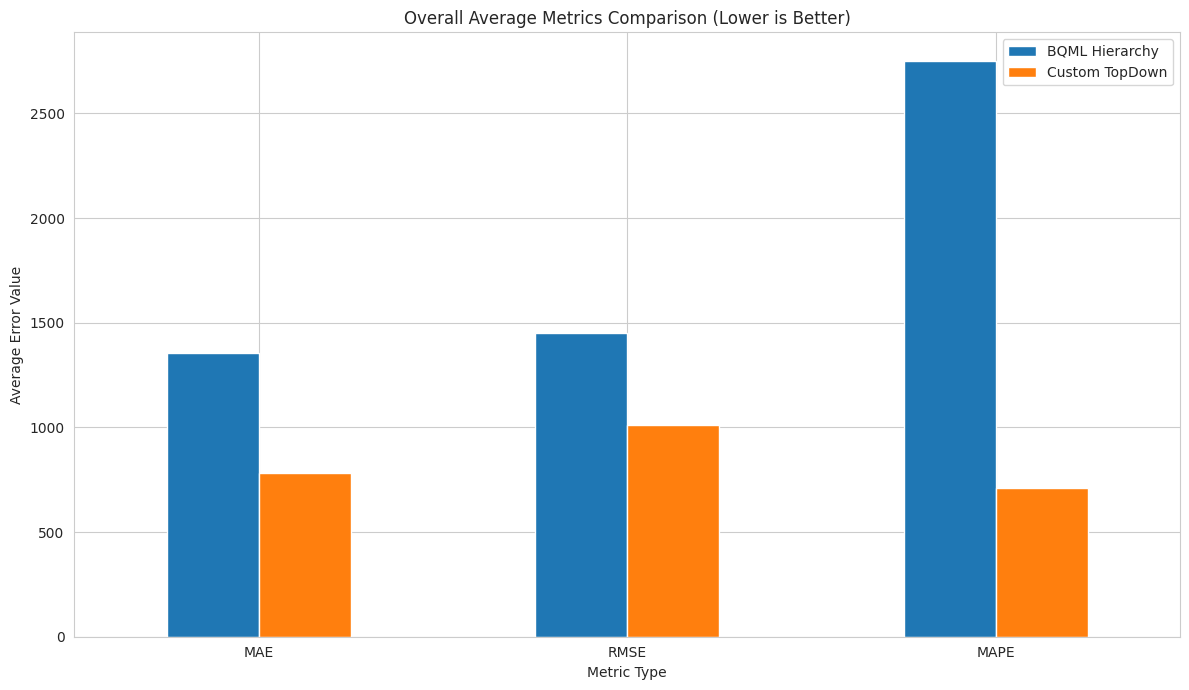

In [69]:
# Select only the metric columns
metric_cols = [col for col in accuracy.columns if 'mae_' in col or 'rmse_' in col or 'mape_' in col]

# Calculate the mean for each metric
overall_avg_metrics = accuracy[metric_cols].mean()

# Define the desired order for comparison in the table
metric_pairs_order = [
    'mae_bqml_hierarchy', 'mae_custom_topdown',
    'rmse_bqml_hierarchy', 'rmse_custom_topdown',
    'mape_bqml_hierarchy', 'mape_custom_topdown'
]

# Reorder the metrics Series for table display
overall_avg_metrics_reordered = overall_avg_metrics.reindex(metric_pairs_order)

print("Overall Average Metrics Across All Series (Reordered):")
print(overall_avg_metrics_reordered)
print("-" * 50)

# --- Visualization ---
# Prepare data for grouped bar chart
plot_data = {
    'BQML Hierarchy': [
        overall_avg_metrics.get('mae_bqml_hierarchy', np.nan),
        overall_avg_metrics.get('rmse_bqml_hierarchy', np.nan),
        overall_avg_metrics.get('mape_bqml_hierarchy', np.nan)
    ],
    'Custom TopDown': [
        overall_avg_metrics.get('mae_custom_topdown', np.nan),
        overall_avg_metrics.get('rmse_custom_topdown', np.nan),
        overall_avg_metrics.get('mape_custom_topdown', np.nan)
    ]
}
index_labels = ['MAE', 'RMSE', 'MAPE']
plot_df = pd.DataFrame(plot_data, index=index_labels)

# Create the grouped bar chart
fig1, ax1 = plt.subplots(figsize=(12, 7))
plot_df.plot(kind='bar', ax=ax1, title='Overall Average Metrics Comparison (Lower is Better)', rot=0)
ax1.set_ylabel('Average Error Value')
ax1.set_xlabel('Metric Type')
plt.tight_layout()
plt.show()

### Average Performance by Hierarchy Level
Understanding how performance varies across different levels of the hierarchy is crucial. This section analyzes the average MAE, RMSE, and MAPE separately for the state, county, city, and store levels.

The code groups the `accuracy` DataFrame by `hierarchy_level` and calculates the mean for each metric column. The resulting table shows the average performance of both methods at each level, with columns reordered for direct comparison. Subsequently, grouped bar charts are generated specifically comparing the average MAE and average MAPE across levels, allowing for a visual assessment of whether one method consistently outperforms the other at certain aggregation levels (e.g., state/county vs. city/store).


Average Metrics by Hierarchy Level (Reordered Columns):
                 mae_bqml_hierarchy  mae_custom_topdown  rmse_bqml_hierarchy  \
hierarchy_level                                                                
state                  51891.891017        13137.839609         54269.829475   
county                 15707.290145         5389.037948         16735.517151   
city                    2795.873216         1477.945278          3030.840125   
store_number             290.900326          440.488460           315.896746   

                 rmse_custom_topdown  mape_bqml_hierarchy  mape_custom_topdown  
hierarchy_level                                                                 
state                   21779.739219          7351.324577           571.469088  
county                   8065.252735         35281.806060         11500.860313  
city                     2006.278900         11336.928052          2451.525486  
store_number              485.796413           610.474474

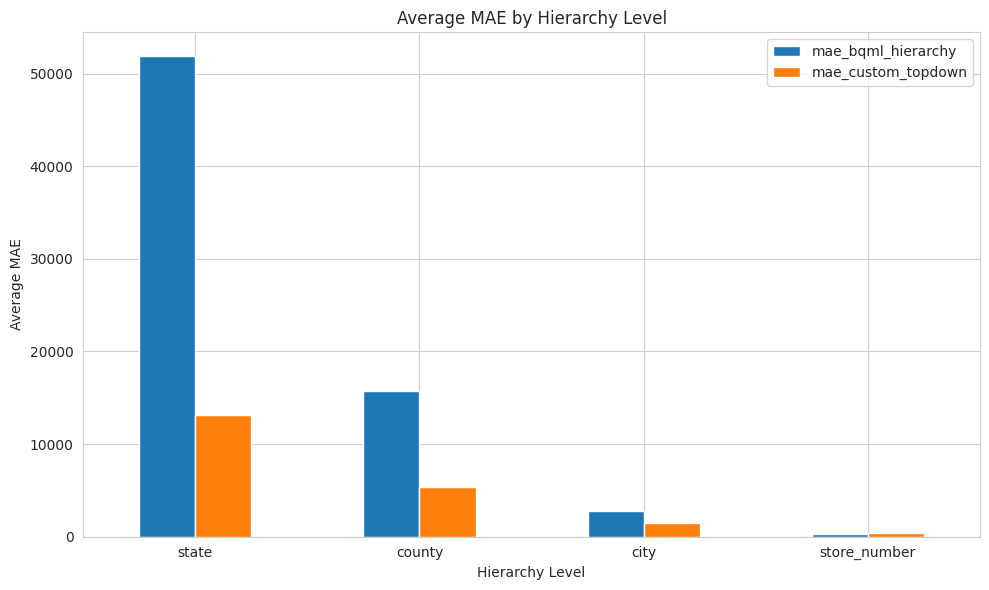

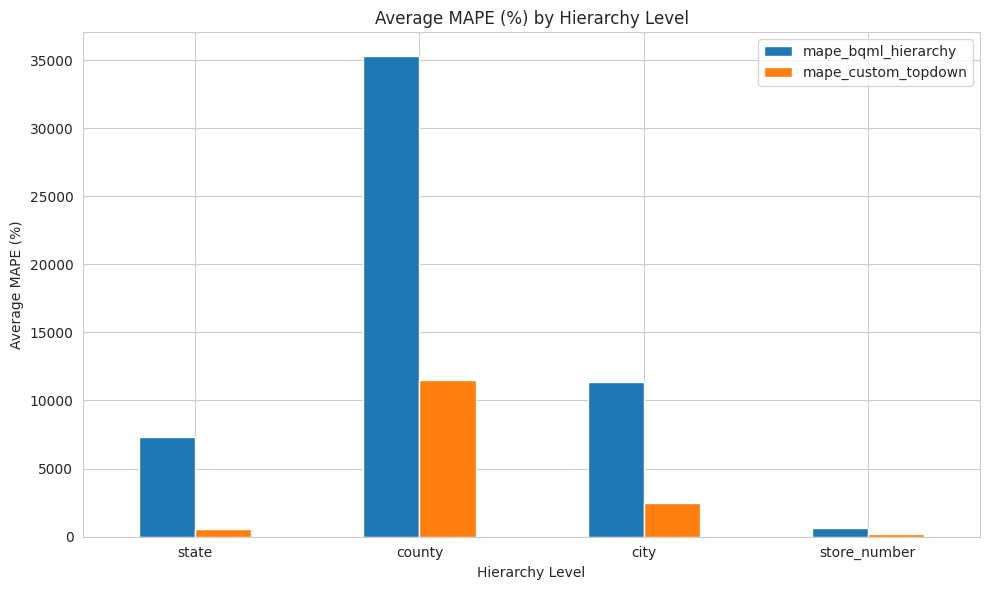

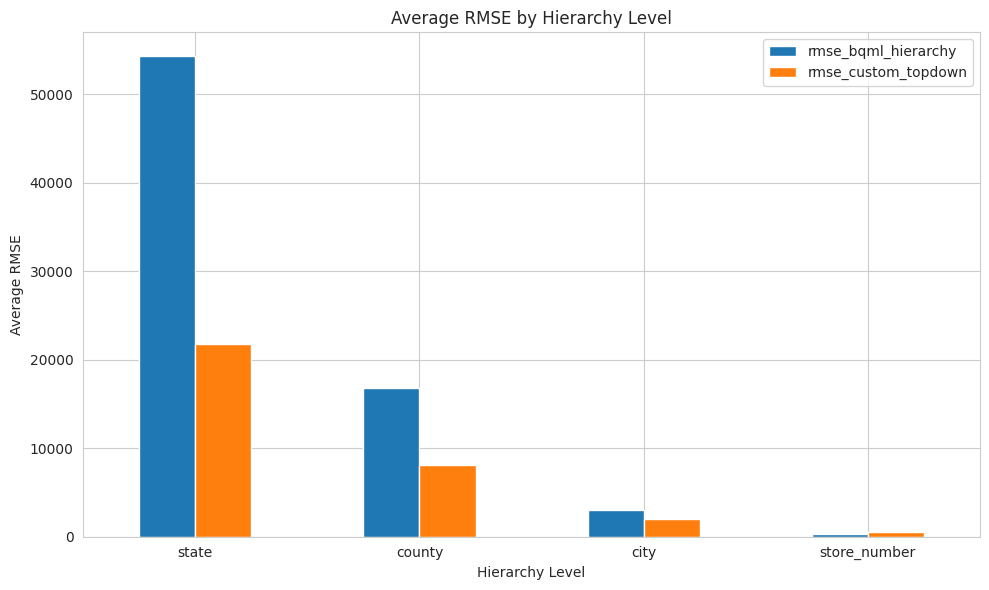

In [64]:
# Group by hierarchy level and calculate mean metrics
avg_metrics_by_level = accuracy.groupby('hierarchy_level')[metric_cols].mean()

# Define the desired order for levels and columns
desired_level_order = ['state', 'county', 'city', 'store_number']
# Use the same metric_pairs_order from Section 1

# Reorder levels (rows)
try:
    avg_metrics_by_level = avg_metrics_by_level.reindex(desired_level_order)
except KeyError:
    print("Note: One or more hierarchy levels might be missing in the desired order.")

# Reorder metrics (columns)
avg_metrics_by_level_reordered = avg_metrics_by_level[metric_pairs_order]


print("\nAverage Metrics by Hierarchy Level (Reordered Columns):")
print(avg_metrics_by_level_reordered)
print("-" * 50)

# --- Visualization ---
# Plot MAE comparison by level
fig2_mae, ax2_mae = plt.subplots(figsize=(10, 6))
avg_metrics_by_level_reordered[['mae_bqml_hierarchy', 'mae_custom_topdown']].plot(
    kind='bar', ax=ax2_mae, title='Average MAE by Hierarchy Level'
)
ax2_mae.set_ylabel('Average MAE')
ax2_mae.set_xlabel('Hierarchy Level')
ax2_mae.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

# Plot MAPE comparison by level
fig2_mape, ax2_mape = plt.subplots(figsize=(10, 6))
avg_metrics_by_level_reordered[['mape_bqml_hierarchy', 'mape_custom_topdown']].plot(
    kind='bar', ax=ax2_mape, title='Average MAPE (%) by Hierarchy Level'
)
ax2_mape.set_ylabel('Average MAPE (%)')
ax2_mape.set_xlabel('Hierarchy Level')
ax2_mape.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

# Plot RMSE comparison by level (Optional - can add if desired)
fig2_rmse, ax2_rmse = plt.subplots(figsize=(10, 6))
avg_metrics_by_level_reordered[['rmse_bqml_hierarchy', 'rmse_custom_topdown']].plot(
    kind='bar', ax=ax2_rmse, title='Average RMSE by Hierarchy Level'
)
ax2_rmse.set_ylabel('Average RMSE')
ax2_rmse.set_xlabel('Hierarchy Level')
ax2_rmse.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

### Method "Win Rate" per Level (Based on MAPE)
Beyond average performance, it's useful to know which method produced a better forecast more often for series within each level. This section calculates the percentage of time each method achieved a lower Mean Absolute Percentage Error (MAPE).

The code compares the `mape_bqml_hierarchy` and `mape_custom_topdown` values for every series. It then counts the "winner" (including ties or cases where comparison wasn't possible) within each `hierarchy_level`. The results are displayed as percentages in a table and visualized using a stacked bar chart. The chart shows the proportion of series at each level for which BQML Hierarchy had lower MAPE versus the Custom TopDown method, providing a clear view of method dominance based on MAPE frequency at each level.


Percentage of Series Where Each Method Had Lower MAPE (per Level):
mape_winner      BQML Hierarchy  Custom TopDown  Tie  No Comparison
hierarchy_level                                                    
state                  0.000000      100.000000    0              0
county                 0.000000      100.000000    0              0
city                  33.333333       66.666667    0              0
store_number          64.814815       35.185185    0              0
--------------------------------------------------


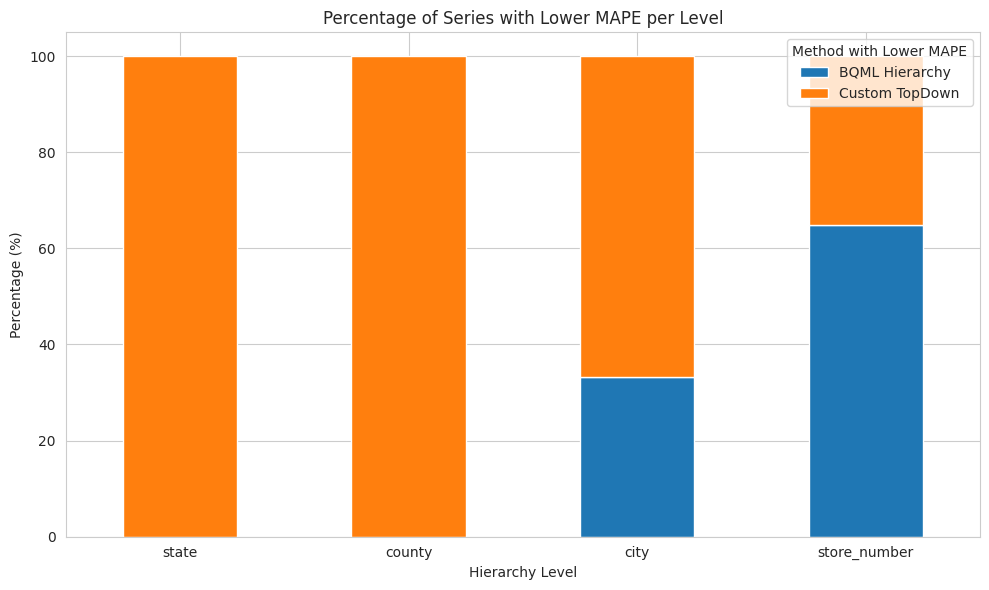

In [65]:
# Determine the winner based on lower MAPE for each series
accuracy['mape_winner'] = np.where(
    accuracy['mape_bqml_hierarchy'] < accuracy['mape_custom_topdown'],
    'BQML Hierarchy',
    'Custom TopDown'
)
# Handle cases where MAPE is equal or potentially NaN (if all actuals were 0)
accuracy.loc[accuracy['mape_bqml_hierarchy'] == accuracy['mape_custom_topdown'], 'mape_winner'] = 'Tie'
accuracy['mape_winner'].fillna('No Comparison', inplace=True) # Handle potential NaNs


# Calculate percentage of wins per level
win_percentage_by_level_mape = accuracy.groupby('hierarchy_level')['mape_winner'] \
                                      .value_counts(normalize=True) \
                                      .mul(100) \
                                      .unstack(fill_value=0)

# Ensure consistent column order
win_percentage_by_level_mape = win_percentage_by_level_mape.reindex(
    columns=['BQML Hierarchy', 'Custom TopDown', 'Tie', 'No Comparison'], fill_value=0
)


print("\nPercentage of Series Where Each Method Had Lower MAPE (per Level):")
# Try reindexing levels again for consistent order
try:
    win_percentage_by_level_mape = win_percentage_by_level_mape.reindex(desired_level_order)
except KeyError:
     print("Note: One or more hierarchy levels might be missing in the desired order.")
print(win_percentage_by_level_mape)
print("-" * 50)


# --- Visualization ---
fig3, ax3 = plt.subplots(figsize=(10, 6))
# Plot only the main competitors, maybe ignore Tie/No Comparison for visual clarity if they are small
win_percentage_by_level_mape[['BQML Hierarchy', 'Custom TopDown']].plot(
    kind='bar',
    stacked=True, # Stacked bar chart shows proportions nicely
    ax=ax3,
    title='Percentage of Series with Lower MAPE per Level'
)
ax3.set_ylabel('Percentage (%)')
ax3.set_xlabel('Hierarchy Level')
ax3.tick_params(axis='x', rotation=0)
ax3.legend(title='Method with Lower MAPE')
plt.tight_layout()
plt.show()

### Identifying Series with Largest MAPE Discrepancies
To understand where the two methods differ most drastically, this section identifies the specific time series exhibiting the largest absolute differences in MAPE.

The code calculates the difference between the Custom TopDown MAPE and the BQML Hierarchy MAPE for each series. It then sorts the data based on this difference and displays two tables: the top 5 series where the Custom TopDown method had the highest relative MAPE (potentially performing much worse) and the top 5 series where it had the lowest relative MAPE (potentially performing much better) compared to the BQML method. Examining these specific series (e.g., their level, location, potential volume) can offer insights into scenarios where one method might be preferred or might struggle.

In [66]:
# Calculate MAPE difference (Custom - BQML) - Positive means Custom MAPE is higher/worse
# Handle potential NaNs in MAPE before calculating difference
accuracy['mape_difference'] = accuracy['mape_custom_topdown'].sub(accuracy['mape_bqml_hierarchy'], fill_value=np.nan)


# Sort by difference to find largest discrepancies
accuracy_sorted_by_mape_diff = accuracy.sort_values('mape_difference', ascending=False, na_position='last')

# Define columns to display, ordered nicely
cols_to_show_mape = [
    'hierarchy_level', 'hierarchy_series', 'hierarchy_parent',
    'mape_bqml_hierarchy', 'mape_custom_topdown', 'mape_difference'
]


print(f"\nTop 5 Series Where Custom TopDown MAPE was HIGHEST relative to BQML Hierarchy:")
print(accuracy_sorted_by_mape_diff[cols_to_show_mape].head())
print("-" * 20)

print(f"\nTop 5 Series Where Custom TopDown MAPE was LOWEST relative to BQML Hierarchy:")
# Need to use ascending=True or simply take tail of descending sort
print(accuracy_sorted_by_mape_diff[cols_to_show_mape].tail())
# Alternative if NaNs interfere with tail:
# print(accuracy.sort_values('mape_difference', ascending=True, na_position='last')[cols_to_show_mape].head())
print("-" * 50)


Top 5 Series Where Custom TopDown MAPE was HIGHEST relative to BQML Hierarchy:
    hierarchy_level hierarchy_series hierarchy_parent  mape_bqml_hierarchy  \
52     store_number             5687     CEDAR RAPIDS             8.803831   
61     store_number            10165        DAVENPORT             5.819256   
36     store_number             4489     CEDAR RAPIDS            15.620542   
124    store_number             6046  WEST DES MOINES            17.042659   
13             city        LE CLAIRE            SCOTT             0.700550   

     mape_custom_topdown  mape_difference  
52             95.584222        86.780391  
61             90.423949        84.604693  
36            100.000000        84.379458  
124           100.000000        82.957341  
13             83.120303        82.419753  
--------------------

Top 5 Series Where Custom TopDown MAPE was LOWEST relative to BQML Hierarchy:
    hierarchy_level hierarchy_series hierarchy_parent  mape_bqml_hierarchy  \
126    st

### Direct State-Level Metrics Comparison
This section focuses solely on the performance metrics for the single, highest level of the hierarchy – the overall state forecast.

The code filters the `accuracy` DataFrame to isolate the row where `hierarchy_level` is 'state'. It then displays the MAE, RMSE, and MAPE values for both the BQML Hierarchy forecast and the Custom TopDown forecast for this specific level, presenting the metric columns side-by-side. This allows for a direct, focused comparison of how accurately each method predicted the total state-level sales according to different error measures.

In [67]:
# Filter for the state level
state_metrics = accuracy[accuracy['hierarchy_level'] == 'state'].copy() # Use .copy() to avoid SettingWithCopyWarning if modifying later

# Select and reorder metric columns for the state level
# Use the same metric_pairs_order from Section 1
state_metrics_reordered = state_metrics[metric_pairs_order]


print("\nMetrics for State Level (Reordered Columns):")
print(state_metrics_reordered)
print("-" * 50)

# Optional: Add the MAPE difference if calculated previously
if 'mape_difference' in state_metrics.columns:
    print("\nState MAPE Difference (Custom - BQML):")
    print(state_metrics['mape_difference'])


Metrics for State Level (Reordered Columns):
    mae_bqml_hierarchy  mae_custom_topdown  rmse_bqml_hierarchy  \
18        51891.891017        13137.839609         54269.829475   

    rmse_custom_topdown  mape_bqml_hierarchy  mape_custom_topdown  
18         21779.739219          7351.324577           571.469088  
--------------------------------------------------

State MAPE Difference (Custom - BQML):
18   -6779.855489
Name: mape_difference, dtype: float64


---
## Remove Resources Created In This Notebook

All the content is contained within the BigQuery dataset named `applied_ml_forecasting` created above.  If you are running other workflows in this series then consider not deleting these until done.  

The following will delete the BigQuery resources created above and the dataset if it is empty.

In [71]:
# to remove resources change this flag to True:
remove = False

In [72]:
if remove:
    # client for BigQuery
    from google.cloud import bigquery
    bq = bigquery.Client(project = 'statmike-mlops-349915')
    
    # delete BigQuery table(s) and model(s) created above
    bq.delete_table('statmike-mlops-349915.applied_ml_forecasting.prepped')
    bq.delete_table('statmike-mlops-349915.applied_ml_forecasting.topdown_results')
    bq.delete_table('statmike-mlops-349915.applied_ml_forecasting.source')
    bq.delete_table('statmike-mlops-349915.applied_ml_forecasting.prepped_topdown')
    bq.delete_model('statmike-mlops-349915.applied_ml_forecasting.base_forecast')
    bq.delete_model('statmike-mlops-349915.applied_ml_forecasting.hierarchical_forecast')
    bq.delete_model('statmike-mlops-349915.applied_ml_forecasting.topdown_forecast')
    
    # delete BigQuery dataset - fails if other content was in the dataset than what this notebook created
    bq.delete_dataset('statmike-mlops-349915.applied_ml_forecasting', delete_contents = False)